In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
#Matplot Images
import matplotlib.image as mpimg
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
#PreTrained Model
from tensorflow.keras.applications import *
#Image Generator DataAugmentation
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Warnings Remove 
import warnings 
warnings.filterwarnings("ignore")
#Splitting Data 
# import splitfolders
from tensorflow.keras.preprocessing import image_dataset_from_directory
import random
from sklearn.cluster import KMeans
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

2024-02-28 18:15:14.037189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 18:15:14.037288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 18:15:14.172857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
directory = "/kaggle/input/paddydoctor/train_images"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [3]:
df_train.head()

,filepath,label
0,/kaggle/input/paddydoctor/train_images/tungro/...,tungro
1,/kaggle/input/paddydoctor/train_images/tungro/...,tungro
2,/kaggle/input/paddydoctor/train_images/tungro/...,tungro
3,/kaggle/input/paddydoctor/train_images/tungro/...,tungro
4,/kaggle/input/paddydoctor/train_images/tungro/...,tungro


In [6]:
from sklearn. model_selection import train_test_split
train_df , val_df = train_test_split(df_train ,train_size = 0.9 , shuffle = True ,random_state = 42 )

In [7]:
print(f"The shape of The Train data is: {train_df.shape}")
print(f"The shape of The Validation data is: {val_df.shape}")

The shape of The Train data is: (9366, 2)
The shape of The Validation data is: (1041, 2)


In [9]:
data_dir = '/kaggle/input/paddydoctor/train_images'

print('Training Images:')
# creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=(256, 256),
    batch_size=32)

#Testing Augmented Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=(256, 256),
    batch_size=32)

Training Images:
Found 10407 files belonging to 10 classes.
Using 9367 files for training.
Validation Images:
Found 10407 files belonging to 10 classes.
Using 1040 files for validation.


In [10]:
test_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/paddydoctor/test_images',
    batch_size = 32,
    image_size = (256, 256),
    label_mode = None,
    shuffle=False
)
test_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

Found 3469 files.


In [11]:
class_names = train_ds.class_names


# Print the class indices
print("Class indices for training generator:", class_names)

Class indices for training generator: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [12]:
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


In [13]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
# Val Data
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

In [14]:
DenseNet121_base = DenseNet121(weights='imagenet',
                                    include_top=False, 
                                   input_shape=(256, 256, 3),
                                     pooling = 'avg'
                                   )

# Freeze the pre-trained base model layers
DenseNet121_base.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
model = Sequential()

# Add the pre-trained DenseNet121_base 
model.add(DenseNet121_base)

# Batch Normalization
model.add(BatchNormalization())

#Dropout 
model.add(Dropout(0.35))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(220, activation='relu'))


# Add the output layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(10, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [16]:
early_stopping = EarlyStopping(
    patience=10, 
    restore_best_weights=True,
)

# Train the model 
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=validation_ds,
                    callbacks=early_stopping)

Epoch 1/10
  1/293 ━━━━━━━━━━━━━━━━━━━━ 3:20:39 41s/step - accuracy: 0.1250 - loss: 2.6311

I0000 00:00:1709144447.841261     181 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709144447.904203     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5119 - loss: 1.4744

W0000 00:00:1709144496.304607     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709144507.146111     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709144526.616226     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


293/293 ━━━━━━━━━━━━━━━━━━━━ 120s 271ms/step - accuracy: 0.5122 - loss: 1.4733 - val_accuracy: 0.7769 - val_loss: 0.7968
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.7574 - loss: 0.7286 - val_accuracy: 0.8154 - val_loss: 0.5372
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.8084 - loss: 0.5697 - val_accuracy: 0.8587 - val_loss: 0.4161
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - accuracy: 0.8412 - loss: 0.4664 - val_accuracy: 0.8750 - val_loss: 0.3411
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.8729 - loss: 0.3903 - val_accuracy: 0.9010 - val_loss: 0.3002
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - accuracy: 0.8923 - loss: 0.3299 - val_accuracy: 0.9087 - val_loss: 0.2671
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.8958 - loss: 0.3007 - val_accuracy: 0.9144 - val_loss: 0.2585
Epoch 8/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - accuracy: 0.9219 - loss: 0.2442 - va

In [17]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9420 - loss: 0.1752
Validation Loss: 0.21770112216472626
Validation Accuracy: 0.9365384578704834


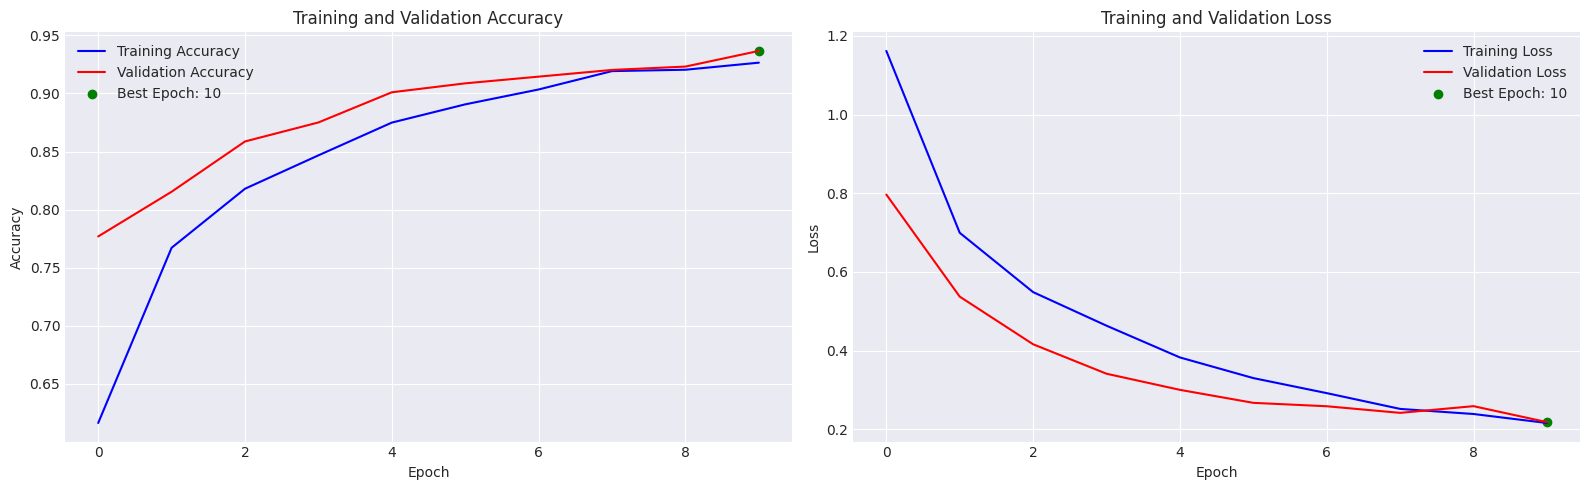

In [18]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()